# iNethi Traffic Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import stats

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

def dataDescribe(df):
    
    df_mean = df.groupby(df.index).mean()
    df_median = df.groupby(df.index).median()
    df_std = df.groupby(df.index).std()
    df_sum = df.groupby(df.index).sum()
    
    months = df.index.unique()
    
    df_desc = pd.DataFrame(columns=['Month','Mean','Median','Std Dev','Variance','Skewness','Kurtosis','Min','Max','Sum'])
    for m in months:
        d = describe(df.loc[df.index==m], axis=0)
        median = df_median[df_median.index==m].bytes[0]
        std = df_std[df_std.index==m].bytes[0]
        total = df_sum[df_sum.index==m].bytes[0] 
        df_desc = df_desc.append({'Month':m,
                                            'Mean':d.mean[0],
                                            'Median': median,
                                            'Std Dev':std,
                                            'Variance': d.variance[0],
                                            'Skewness': d.skewness[0],
                                            'Kurtosis': d.kurtosis[0],
                                            'Min': d.minmax[0][0],
                                            'Max': d.minmax[1][0],
                                            'Sum': total
                                           } , ignore_index=True)

    return df_desc


## Overall Traffic stats
Traffic is coming from three main locations: mesh, school and servers. 

In [3]:
df_stats = pd.read_csv('data/stats/traffic_stats.csv', parse_dates=True)

In [5]:
df_stats.tail()

,date,location,protocol,src_ip,dest_ip,download_frames,download_bytes,upload_frames,upload_bytes,total_frames,total_bytes,relative_start,duration
92216393,2019-12-19 07:50:02,school,udp,10.5.10.43:59313,8.8.8.8:53,0,0,1,80,1,80,2173.101624,0.0
92216394,2019-12-19 07:50:02,school,udp,10.5.10.43:46295,8.8.8.8:53,0,0,1,75,1,75,2177.018530,0.0
92216395,2019-12-19 07:50:02,school,udp,10.5.10.43:51437,8.8.8.8:53,0,0,1,98,1,98,2177.588674,0.0
92216396,2019-12-19 07:50:02,school,udp,fe80::4431:f0a6:c7d3:4727:54526,ff02::1:3:5355,0,0,1,94,1,94,2188.785237,0.0
92216397,2019-12-19 07:50:02,school,udp,10.5.11.125:54526,224.0.0.252:5355,0,0,1,74,1,74,2188.785241,0.0


In [6]:
df_udp = df_stats.loc[df_stats.protocol=='udp']
df_tcp = df_stats.loc[df_stats.protocol=='tcp']

In [7]:
df_total = df_stats.groupby('date')['date','download_bytes', 'upload_bytes'].sum()
df_total.head()

,download_bytes,upload_bytes
date,,
2019-07-29 17:35:23,201354,157683
2019-07-29 17:56:02,61425430,11137756
2019-07-29 18:56:02,350158577,24938679
2019-07-29 19:56:02,576221228,40555215
2019-07-29 19:56:03,812172,643600


In [8]:
df_total.index = pd.to_datetime(df_total.index, dayfirst=False) 

In [9]:
df_total = df_total.resample('D').sum()

In [10]:
df_total['download_bytes'] = df_total.apply(lambda x: x.download_bytes/1e+9, axis=1)
df_total['upload_bytes'] = df_total.apply(lambda x: x.upload_bytes/1e+9, axis=1)


In [11]:
df_total['month'] = pd.DatetimeIndex(df_total.index).month
df_total['month'] = df_total['month'].apply(lambda x: calendar.month_abbr[x])

In [12]:
df_total = df_total[df_total.month != 'Jul']
df_total = df_total.set_index('month')

In [13]:
df_total_download = df_total.iloc[:,[0]]
df_total_upload = df_total.iloc[:,[1]]

In [14]:
df_total_download = df_total_download.rename(columns={"download_bytes": "bytes"})
df_total_upload = df_total_upload.rename(columns={"upload_bytes": "bytes"})

In [16]:
df_total_upload.tail()

,bytes
month,
Feb,0.192640
Feb,0.188107
Feb,0.257401
Feb,0.494519
Feb,0.746484


### Descriptive statistics of daily IP data upload traffic in GB

In [19]:
dataDescribe(df_total_upload).set_index('Month').T

Month,Aug,Sep,Oct,Nov,Dec,Jan,Feb
Mean,0.645751,0.814197,1.003795,1.125243,0.265386,0.218016,0.410353
Median,0.677159,0.662563,0.935176,0.735589,0.125451,0.105446,0.375960
Std Dev,0.417203,0.653246,0.329570,0.766450,0.254682,0.243469,0.232400
Variance,0.174059,0.426731,0.108616,0.587446,0.064863,0.059277,0.054010
Skewness,-0.169892,3.759795,1.082069,1.409013,1.165188,1.547803,0.328876
Kurtosis,-0.678895,14.852591,0.920238,0.750824,-0.047350,0.625350,-1.441975
Min,0.000000,0.202088,0.514279,0.522518,0.000283,0.064312,0.188107
Max,1.504647,3.887980,1.905849,3.172944,0.892002,0.846750,0.746484
Sum,20.018267,24.425899,31.117639,33.757285,8.226978,6.758492,2.462118


In [20]:
dataDescribe(df_total_download).set_index('Month').T

Month,Aug,Sep,Oct,Nov,Dec,Jan,Feb
Mean,5.931447,7.252217,12.406834,10.233907,2.066694,1.810570,5.492633
Median,6.953376,6.944968,10.480060,8.764038,0.078198,0.062229,4.703142
Std Dev,3.547000,2.129489,6.666412,4.878379,3.465544,3.530458,4.478315
Variance,12.581212,4.534723,44.441044,23.798583,12.009993,12.464131,20.055304
Skewness,-0.715925,0.043364,1.737211,1.750805,1.445578,1.693758,0.715109
Kurtosis,-0.887896,-0.293431,3.237267,3.886928,0.515551,1.232929,-0.764472
Min,0.000000,2.434725,4.779715,5.109839,0.000190,0.032167,1.503306
Max,11.133038,11.291630,35.645405,28.022926,10.939196,11.410271,13.018902
Sum,183.874857,217.566513,384.611856,307.017201,64.067516,56.127682,32.955798


### Boxplot of download and upload traffic

In [21]:
df_total_download['type'] = "download"
df_total_upload['type'] = "upload"

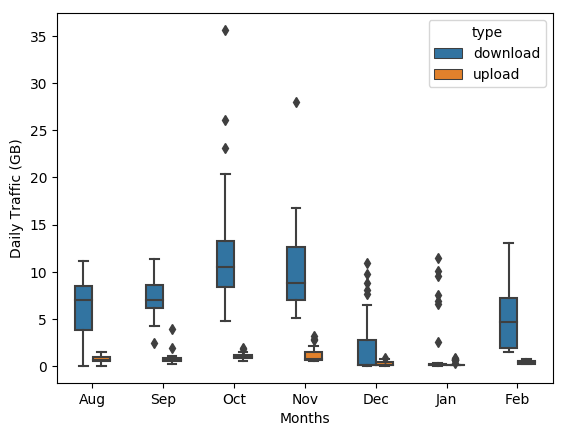

In [22]:
df_merged = pd.concat([df_total_download, df_total_upload])

ax = sns.boxplot(y='bytes', x=df_merged.index, 
                 data=df_merged, 
                 #palette="colorblind",
                 hue='type', width=0.5)

ax.set(xlabel='Months', ylabel='Daily Traffic (GB)')
plt.savefig('plots/box_plot_traffic.pdf')
plt.show()


### Daily traffic pattern - UDP vs TCP

In [27]:
df_download = df_stats.iloc[:,[0,2,6]]
df_download = df_download.groupby(['date','protocol'])['download_bytes'].sum().reset_index()
df_download = df_download.pivot(index='date', columns='protocol', values='download_bytes').reset_index()
df_download.columns = ['date', 'tcp_down','udp_down']

df_upload = df_stats.iloc[:,[0,2,8]]
df_upload = df_upload.groupby(['date','protocol'])['upload_bytes'].sum().reset_index()
df_upload = df_upload.pivot(index='date', columns='protocol', values='upload_bytes').reset_index()
df_upload.columns = ['date', 'tcp_up','udp_up']

df_downup = df_upload.merge(df_download, left_on='date', right_on='date', suffixes=(False, False))
df_downup['download'] = df_downup.tcp_down + df_downup.udp_down
df_downup['upload'] = df_downup.tcp_up + df_downup.udp_up

df_downup.index = pd.to_datetime(df_downup.date, dayfirst=False) 
df_downup = df_downup.resample('D').sum()
df_downup = df_downup[['tcp_up', 'udp_up', 'tcp_down', 'udp_down', 'download', 'upload']].div(1e+9, axis=0)
df_downup = df_downup.reset_index()

In [28]:
df_downup.head()

,date,tcp_up,udp_up,tcp_down,udp_down,download,upload
0,2019-07-29,0.132042,0.032456,1.690148,0.857724,2.547873,0.164498
1,2019-07-30,0.611220,0.053401,7.928463,0.311054,8.239517,0.664620
2,2019-07-31,0.551959,0.056417,6.047372,0.354916,6.402288,0.608375
3,2019-08-01,0.686945,0.049894,7.722831,0.352709,8.075540,0.736838
4,2019-08-02,0.536750,0.059800,6.457490,0.495886,6.953376,0.596550


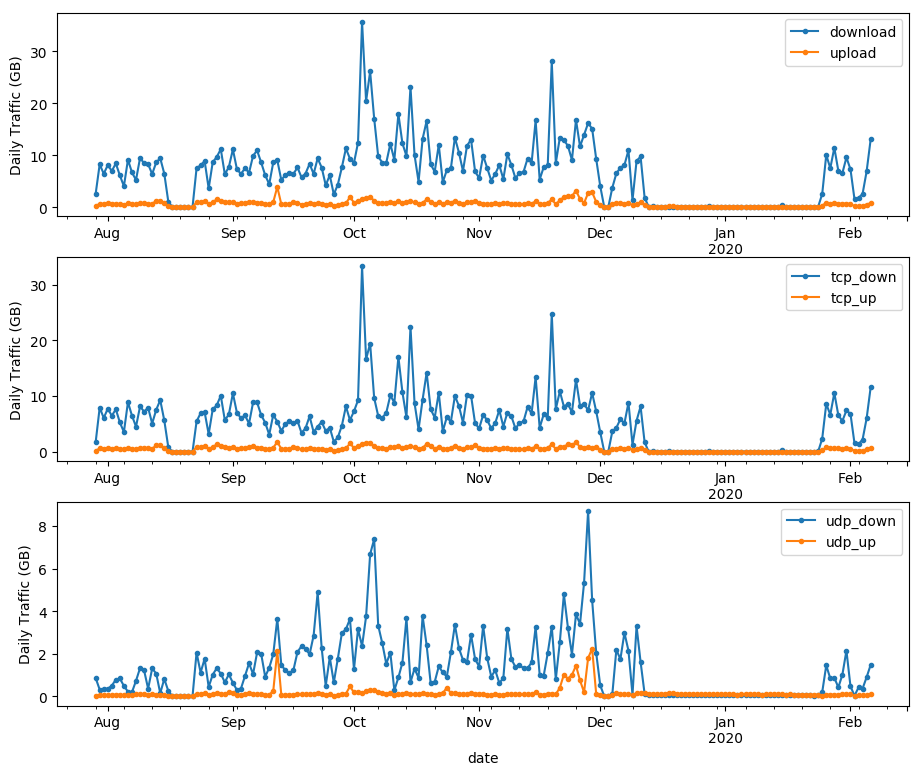

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1)

df_downup.plot(ax=axes[0], x="date", y=["download", "upload"], kind="line", marker='.', linestyle='-', figsize=(11, 9))
df_downup.plot(ax=axes[1], x="date", y=["tcp_down", "tcp_up"], kind="line", marker='.', linestyle='-', figsize=(11, 9))
df_downup.plot(ax=axes[2], x="date", y=["udp_down", "udp_up"], kind="line", marker='.', linestyle='-', figsize=(11, 9))

for ax in axes:
    ax.set_ylabel('Daily Traffic (GB)')

plt.savefig('plots/daily_traffic_tcp_ucp.pdf')
plt.show()

### Split between mesh, school and servers

In [31]:
df_download1 = df_stats.iloc[:,[0,1,6]]
df_download1 = df_download1.groupby(['date','location'])['download_bytes'].sum().reset_index()
df_download1 = df_download1.pivot(index='date', columns='location', values='download_bytes').reset_index()
df_download1.columns = ['date', 'mesh_down','school_down', 'servers_down']

df_upload1 = df_stats.iloc[:,[0,1,8]]
df_upload1 = df_upload1.groupby(['date','location'])['upload_bytes'].sum().reset_index()
df_upload1 = df_upload1.pivot(index='date', columns='location', values='upload_bytes').reset_index()
df_upload1.columns = ['date', 'mesh_up','school_up', 'servers_up']

df_downup1 = df_upload1.merge(df_download1, left_on='date', right_on='date', suffixes=(False, False))
df_downup1['download'] = df_downup1.mesh_down + df_downup1.school_down + df_downup1.servers_down
df_downup1['upload'] = df_downup1.mesh_up + df_downup1.school_up + df_downup1.servers_up

df_downup1.index = pd.to_datetime(df_downup1.date, dayfirst=False) 
df_downup1 = df_downup1.resample('D').sum()
df_downup1 = df_downup1[['mesh_down', 'school_down', 'mesh_up', 'school_up','servers_down','servers_up','download','upload']].div(1e+9, axis=0)
df_downup1 = df_downup1.reset_index()

In [34]:
df_downup1.tail()

,date,mesh_down,school_down,mesh_up,school_up,servers_down,servers_up,download,upload
188,2020-02-02,1.488466,0.002506,0.187679,0.001944,0.012334,0.003017,0.011205,0.008615
189,2020-02-03,1.645933,0.042975,0.144278,0.023332,0.064005,0.020497,0.031817,0.017574
190,2020-02-04,2.250239,0.262563,0.213696,0.034496,0.032761,0.009209,0.000000,0.000000
191,2020-02-05,4.036434,2.786335,0.307381,0.182011,0.037952,0.005126,1.901849,0.140098
192,2020-02-06,5.027828,7.949561,0.358910,0.380252,0.041512,0.007322,0.106291,0.013669


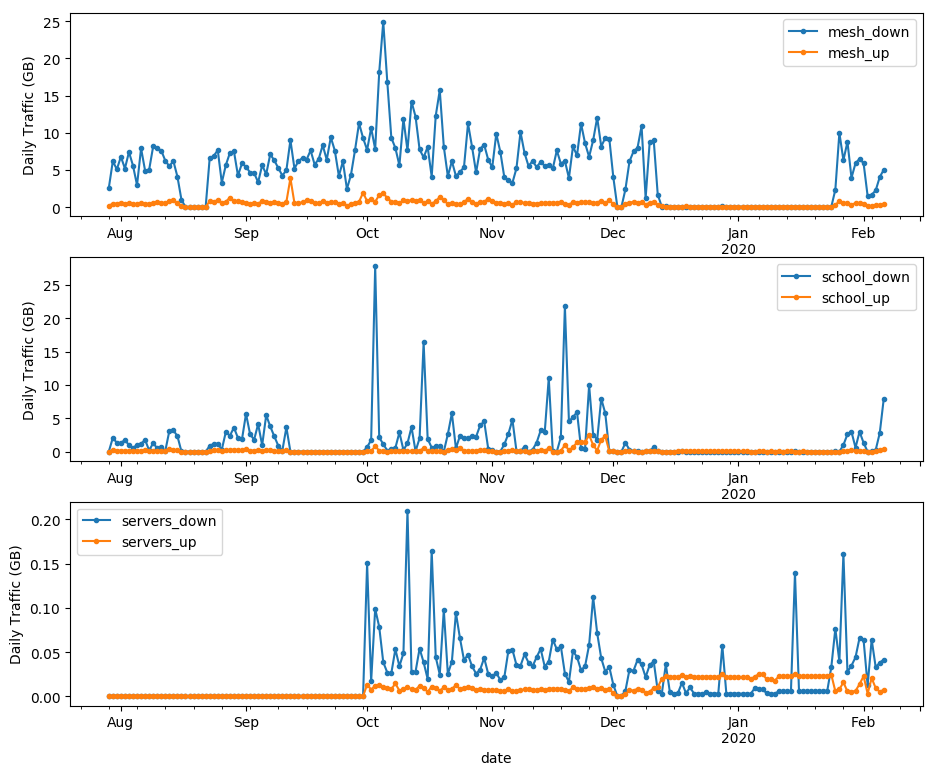

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=1)

df_downup1.plot(ax=axes[0], x="date", y=["mesh_down", "mesh_up"], kind="line", marker='.', linestyle='-', figsize=(11, 9))
df_downup1.plot(ax=axes[1], x="date", y=["school_down", "school_up"], kind="line", marker='.', linestyle='-', figsize=(11, 9))
df_downup1.plot(ax=axes[2], x="date", y=["servers_down", "servers_up"], kind="line", marker='.', linestyle='-', figsize=(11, 9))

for ax in axes:
    ax.set_ylabel('Daily Traffic (GB)')

plt.savefig('plots/daily_traffic_location.pdf')
plt.show()

### A CDF of the total daily traffic

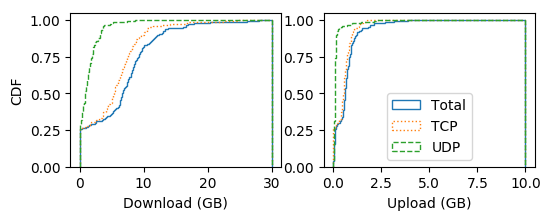

In [70]:
n_bins = 500

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))

ax1.hist(df_downup['download'], n_bins, density=1, histtype='step', range=[0, 30], 
                     linewidth=1, cumulative=True, label="Total")
ax1.hist(df_downup['tcp_down'], n_bins, density=1, histtype='step', range=[0, 30], 
                     linewidth=1, cumulative=True, label="TCP", linestyle=":")
ax1.hist(df_downup['udp_down'], n_bins, density=1, histtype='step', range=[0, 30], 
                     linewidth=1, cumulative=True, label="UDP", linestyle="--")

ax2.hist(df_downup['upload'], n_bins, density=1, histtype='step', range=[0, 10], 
                     linewidth=1, cumulative=True, label="Total")
ax2.hist(df_downup['tcp_up'], n_bins, density=1, histtype='step', range=[0, 10], 
                     linewidth=1, cumulative=True, label="TCP", linestyle=":")
ax2.hist(df_downup['udp_up'], n_bins, density=1, histtype='step', range=[0, 10], 
                     linewidth=1, cumulative=True, label="UDP", linestyle="--")

# tidy up the figure
#ax1.grid(True)
ax2.legend(loc='lower center')
#ax.set_title('CDF Download vs Upload')
ax1.set_xlabel('Download (GB)')
ax2.set_xlabel('Upload (GB)')
ax1.set_ylabel('CDF')

plt.savefig("plots/cdf_download_vs_upload.pdf")
plt.show()


### CDF Mesh vs school vs servers

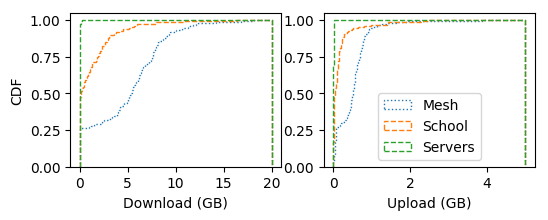

In [73]:
n_bins = 500

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))

ax1.hist(df_downup1['mesh_down'], n_bins, density=1, histtype='step', range=[0, 20], 
                     linewidth=1, cumulative=True, label="Mesh", linestyle=":")
ax1.hist(df_downup1['school_down'], n_bins, density=1, histtype='step', range=[0, 20], 
                     linewidth=1, cumulative=True, label="School", linestyle="--")
ax1.hist(df_downup1['servers_down'], n_bins, density=1, histtype='step', range=[0, 20], 
                     linewidth=1, cumulative=True, label="Servers", linestyle="--")

ax2.hist(df_downup1['mesh_up'], n_bins, density=1, histtype='step', range=[0, 5], 
                     linewidth=1, cumulative=True, label="Mesh", linestyle=":")
ax2.hist(df_downup1['school_up'], n_bins, density=1, histtype='step', range=[0, 5], 
                     linewidth=1, cumulative=True, label="School", linestyle="--")
ax2.hist(df_downup1['servers_up'], n_bins, density=1, histtype='step', range=[0, 5], 
                     linewidth=1, cumulative=True, label="Servers", linestyle="--")

# tidy up the figure
#ax1.grid(True)
ax2.legend(loc='lower center')
#ax.set_title('CDF Download vs Upload')
ax1.set_xlabel('Download (GB)')
ax2.set_xlabel('Upload (GB)')
ax1.set_ylabel('CDF')

plt.savefig("plots/cdf_download_vs_upload_location.pdf")
plt.show()


### Scatterplot of download vs upload

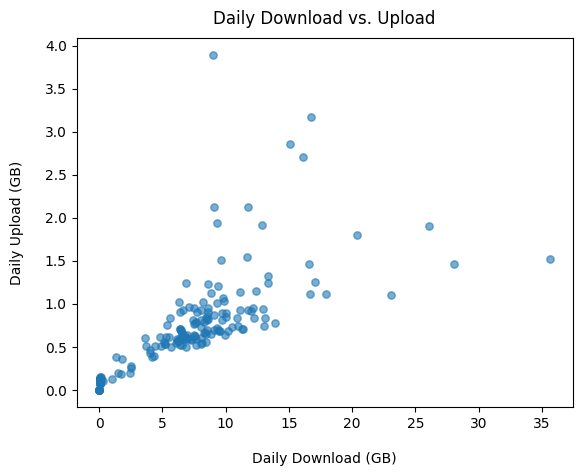

In [37]:
df_total.plot.scatter(x='download_bytes',y='upload_bytes', s=28, alpha=0.6)
plt.xlabel("Daily Download (GB)", labelpad=15)
plt.ylabel("Daily Upload (GB)", labelpad=15)
plt.title("Daily Download vs. Upload", y=1.015)

plt.savefig("plots/scatter_download_vs_upload.pdf")
plt.show()


#### Pearson's Correlation Coefficient

In [38]:
round(stats.pearsonr(df_total['download_bytes'], df_total['upload_bytes'])[0], 2)

0.74

### Monthly frequency distribution

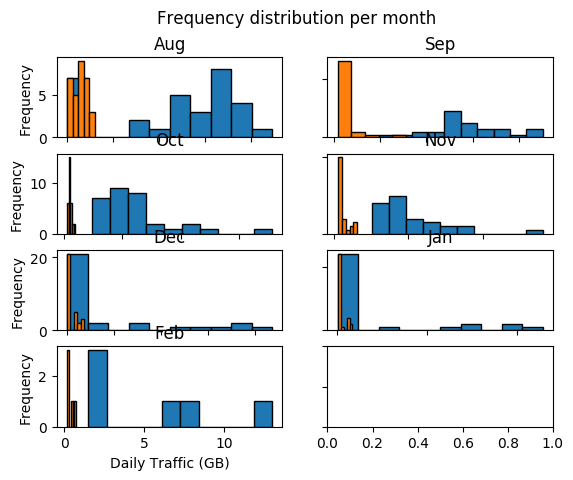

In [40]:
fig, axes = plt.subplots(4, 2)
fig.suptitle('Frequency distribution per month')

axes = axes.ravel()

count_ax = 0
for month in df_total.index.unique():
    axes[count_ax].hist(df_total.loc[df_total.index==month]['download_bytes'], 10, histtype='bar', edgecolor = 'black',#range=[0, 500], 
                         linewidth=1,  label="Download")
    axes[count_ax].hist(df_total.loc[df_total.index==month]['upload_bytes'], 5, histtype='bar', edgecolor = 'black',#range=[0, 500], 
                         linewidth=1,  label="Upload")
    axes[count_ax].set_title(month)
    axes[count_ax].set(xlabel='Daily Traffic (GB)', ylabel='Frequency')
    count_ax = count_ax + 1


for ax in fig.get_axes():
    ax.label_outer()


#ax1.set(xlabel='Daily Traffic (GB)', ylabel='Frequency')